In [1]:
from Bio import SeqIO
from embeddings_config import avail_models
import numpy as np
import os
import argparse

def get_sequences(fastadir=None, fastafile=None):
    sequences = []
    if fastadir is None and fastafile is None:
        print("No fasta dir or file")
        raise
    if fastadir is not None and fastafile is not None:
        print("Choose one, fasta dir or multi fasta filr")
        raise
    # check for a directory with individual fasta files
    # or a multi fasta file
    if fastadir is not None:
        fastafiles = os.listdir(fastadir)
        for f in fastafiles:
            counter = 0
            for record in SeqIO.parse(os.path.join(fastadir, f), "fasta"):
                sequences.append(record)
                counter += 1
                if counter > 1:
                    print("More than one fasta record?", f)
                    raise
    elif fastafile is not None:
        for record in SeqIO.parse(fastafile, "fasta"):
            sequences.append(record)
    return sequences

sel_embedding = 'halft5'
fastadir=None
fastafile=None
annotdir=None
annotfile=None

# Disprot
fastadir="/data/franco/datasets/disprot/fasta/"
annotfile="/data/franco/datasets/disprot/DisProt_release_2022_06_reformat_annot.fasta"
embeddir="/data/franco/datasets/prot_embedding_weights/disprot/halft5/"

# Monomers
# fastafile="/data/franco/datasets/disprot/monomers.fasta"
# annotfile="/data/franco/datasets/disprot/monomers_annot.fasta"
# embeddir="/data/franco/datasets/prot_embedding_weights/monomers/halft5/"

if sel_embedding not in avail_models:
    print("ERROR: Selected model not available")
    raise

sequences = get_sequences(fastadir=fastadir, fastafile=fastafile)
annots    = get_sequences(fastadir=annotdir, fastafile=annotfile)

In [2]:
# find annotation for each sequence
# read annotation data first
annot_dict = dict()
for record in annots:
    if "|" in record.name:
        name = record.name.split("|")[1].strip()
    else:
        name = record.name.split()[0].strip()
        if name == "":
            print("Name is empty",record.name)
    annot_dict[name] = str(record.seq)

In [3]:
all_dict = dict()

In [4]:
# dictionary with input sequences, embeddings and disorder annotation
all_dict = dict()
disseqs = list()
embeddings = list()
selected_sequences = list()

# grab one sequence
for i,s in enumerate(sequences):
    if i > 10:
        break
    if "|" in s.name:
        name = s.name.split("|")[1].strip()
    else:
        name = s.name.split()[0].strip()
        if name == "":
            print("Name is empty",s.name)
            raise
    print(f"working on {name}")
    aa_sequence = str(s.seq).upper()
    if len(aa_sequence) > 1200:
        print(f"Skipping {name}, len={len(aa_sequence)}")
        continue
    embed_file = os.path.join(embeddir, name+".gz")
    if os.path.exists(embed_file):
        if len(s.seq) == len(annot_dict[name]):
            # read embedding
            e = np.loadtxt(embed_file)
            # add annot, seq and embedding
            if len(s.seq) == e.shape[0]:
                all_dict[name] = dict()
                all_dict[name]["disorder"] = annot_dict[name]
                all_dict[name]["embedding"]= e
                all_dict[name]["seq"] = aa_sequence
            else:
                print("Embedding length and seq do not match")
                print(e.shape, len(s.seq), name)
        else:
            print("Sequence and annotation length do not match")
            print(len(s.seq), len(annot_dict[name]), name)
    else:
        ## skip this file
        print(f"skipped {embed_file} does not exist")
        continue

working on P01555
working on P08621
working on P0ABQ4
working on Q15418
working on O95278
working on Q05128
working on O60880
working on Q9U3S5
working on Q9NRR4
Skipping Q9NRR4, len=1374
working on Q9C000
Skipping Q9C000, len=1473
working on Q70Q12


In [5]:
## Pick one protein for regression
all_names = list(all_dict.keys())

uniprot = all_names[0]
disorder = all_dict[uniprot]["disorder"]
Y = np.array([d != "-" for d in disorder], dtype=np.int8)
X = all_dict[uniprot]["embedding"]

# ## Concat all proteins for regression [Done below!]
# all_embeddings = list()
# all_annots     = ""
# for u in all_names:
#     disorder = all_dict[u]["disorder"]
#     all_annots = all_annots + disorder
#     all_embeddings.append(all_dict[u]['embedding'])

# X = np.vstack(all_embeddings)
# Y = np.array([d != "-" for d in all_annots], dtype=np.int8)

print(X.shape, Y.shape)

(258, 1024) (258,)


In [7]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet

# regenet = ElasticNet().fit(X, Y)
# r2_enet = regenet.score(X,Y)

def tjur_r2(model, X, Y):
    true_negatives_ix = Y == 0
    true_positives_ix = Y == 1
    yhat = model.predict(X)
    pi_neg = np.mean(yhat[true_negatives_ix])
    pi_pos = np.mean(yhat[true_positives_ix])
    r2 = pi_pos - pi_neg
    return r2
    
def regress_each_dimension_linear(X,Y):
    reg = LinearRegression()
    myrlist = list()
    mycoef  = list()
    for i in range(X.shape[1]):
        x = X[:,i][:, np.newaxis]
        reg.fit(x, Y)
        myrlist.append(reg.score(x, Y))
        mycoef.append(reg.coef_)
    return myrlist, mycoef

def regress_each_dimension_logistic(X,Y):
    reg = LogisticRegression(penalty='none',class_weight='balanced')
    myrlist = list()
    mytjur_r2 = list()
    mycoef  = list()
    for i in range(X.shape[1]):
        x = X[:,i][:, np.newaxis]
        reg.fit(x, Y)
        myrlist.append(reg.score(x, Y))
        mycoef.append(reg.coef_)
        mytjur_r2.append(tjur_r2(reg, x, Y))
    return myrlist, mycoef, mytjur_r2


res_linear, coef_lin = regress_each_dimension_linear(X,Y)
res_logist, coef_log, mytjur_r2 = regress_each_dimension_logistic(X,Y)
print(np.mean(res_linear))
print(np.mean(res_logist))
print(np.mean(mytjur_r2))

0.046435623218453397
0.5857974503391472
0.17097146551081677


In [8]:
# One coefficient per dimension, one r2 per dimension accross all residues in a protein
print(len(coef_lin), len(coef_log))
print(len(res_linear), len(res_logist))

1024 1024
1024 1024


In [25]:
# find dimension that explains the most in linear / logistic models

linear_best_dim = np.argmax(res_linear)
log_best_dim    = np.argmax(res_logist)
logD_best_dim   = np.argmax(mytjur_r2)

print(linear_best_dim, log_best_dim, logD_best_dim)

591 591 294


In [36]:
from scipy.special import expit

y_line = expit(xref*reglog.coef_ + reglog.intercept_).ravel()

0.9496124031007752 dim=591 D=0.8989012860914743
0.937984496124031 dim=294 D=0.9076739630355166
0.6640169493559485 dim=591


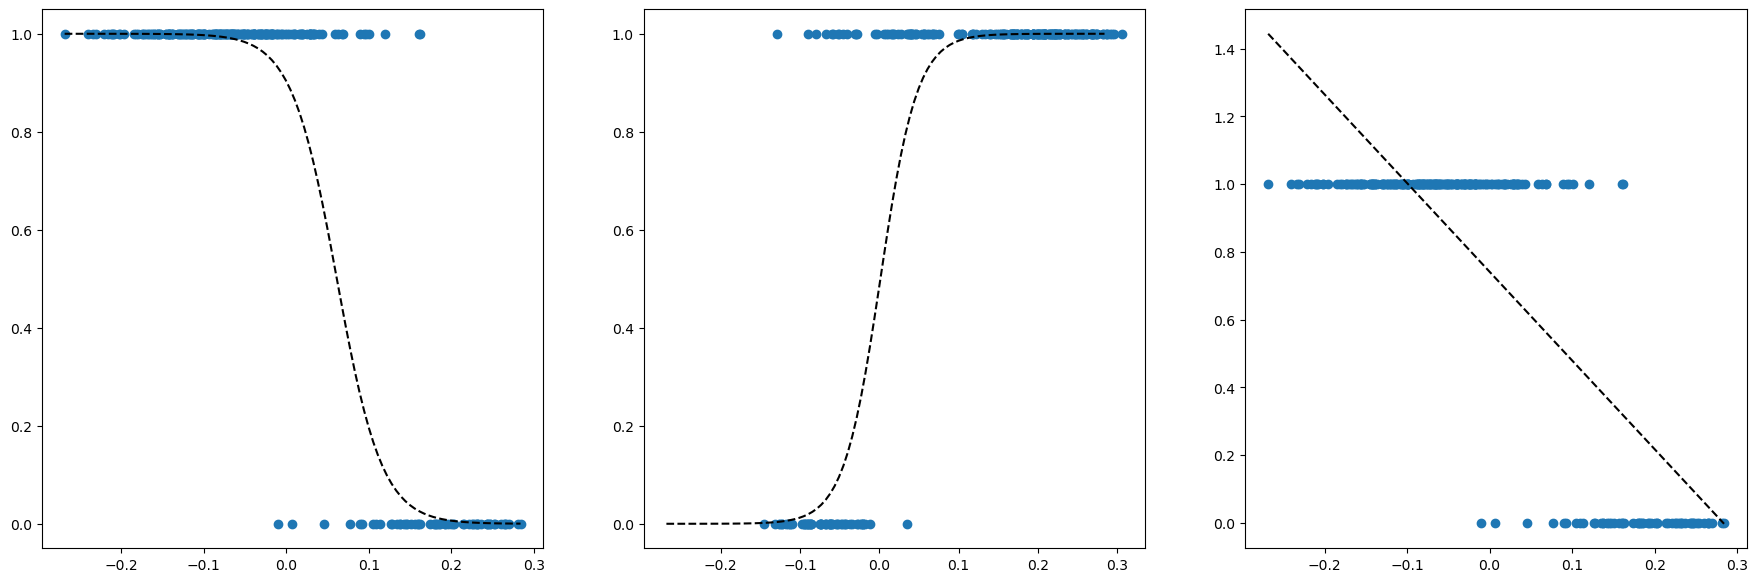

In [54]:
import matplotlib.pyplot as plt
from scipy.special import expit

i = log_best_dim
x = X[:,i][:, np.newaxis]
reglog = LogisticRegression(penalty='none', class_weight='balanced')
reglog.fit(x, Y)
D = tjur_r2(reglog, x, Y)
print(reglog.score(x, Y), f"dim={i} D={D}")

xref = np.linspace(min(x),max(x),100)
y_line = 1 / ( 1 + np.exp((-xref*reglog.coef_) + reglog.intercept_)[0])
y_line2 = expit(xref*reglog.coef_ + reglog.intercept_).ravel()

fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(131)
# ax1.plot(xref, y_line, color="red", linestyle='dashed')
ax1.plot(xref, y_line2, color="black", linestyle='dashed')
ax1.scatter(x, Y)

i = logD_best_dim
x = X[:,i][:, np.newaxis]
reglog = LogisticRegression(penalty='none', class_weight='balanced')
reglog.fit(x, Y)
D = tjur_r2(reglog, x, Y)
print(reglog.score(x, Y), f"dim={i} D={D}")

y_line = 1 / ( 1 + np.exp((xref*reglog.coef_) - reglog.intercept_)[0])
y_line2 = expit(xref*reglog.coef_ + reglog.intercept_).ravel()

ax2 = fig.add_subplot(132)
# ax2.plot(xref, y_line, color="red", linestyle='dashed')
ax2.plot(xref, y_line2, color="black", linestyle='dashed')
ax2.scatter(x, Y)


i = linear_best_dim
x = X[:,i][:, np.newaxis]
reglin = LinearRegression()
reglin.fit(x, Y)
print(reglin.score(x, Y), f"dim={i}")

y_line = xref*reglin.coef_ + reglin.intercept_

ax3 = fig.add_subplot(133)
ax3.plot(xref, y_line, color="black", linestyle='dashed')
ax3.scatter(x, Y)

plt.show()

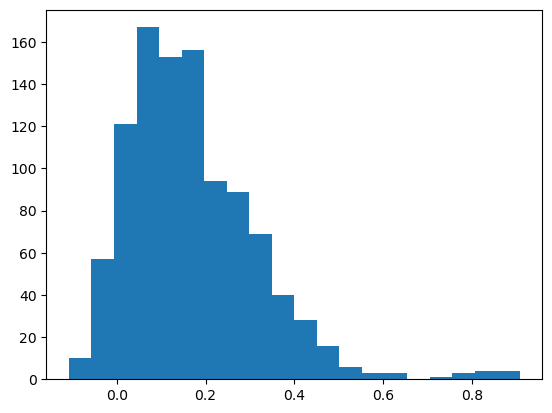

In [61]:
plt.hist(mytjur_r2, bins=20)
plt.show()

In [10]:
# Tjur coefficient of discrimination (R2) 
# https://www.methodspace.com/blog/whats-the-best-r-squared-for-logistic-regression
# https://www.jstor.org/stable/25652317?seq=4#metadata_info_tab_contents
# https://github.com/easystats/performance/blob/HEAD/R/r2_tjur.R

'''
true_negatives_ix = Y == 0
true_positives_ix = Y == 1
yhat = reg.predict(x)
pi_neg = np.mean(yhat[true_negatives_ix])
pi_pos = np.mean(yhat[true_positives_ix])
r2 = pi_pos - pi_neg

print(r2, pi_pos, pi_neg)
'''

'\ntrue_negatives_ix = Y == 0\ntrue_positives_ix = Y == 1\nyhat = reg.predict(x)\npi_neg = np.mean(yhat[true_negatives_ix])\npi_pos = np.mean(yhat[true_positives_ix])\nr2 = pi_pos - pi_neg\n\nprint(r2, pi_pos, pi_neg)\n'

In [11]:
#### Redo but for entire embeddings concatenated

import umap
import numpy as np
import os
import argparse
import time

embedmatfile = "disprot_plotdata/halft5/embedding_data.txt.npz"
# load seq and annotation data
seqfile = "disprot_plotdata/halft5/seq_data.txt"
annfile = "disprot_plotdata/halft5/annot_data.txt"

with open(seqfile) as instr:
    seq = instr.readlines()[0]
    
with open(annfile) as instr:
    annot = instr.readlines()[0]
    
print(len(seq), len(annot))
SEQ = [aa for aa in seq]
ANNOT = [an for an in annot]
AAs = set(SEQ)

903246 903246


In [12]:
s = time.time()
print("Loading embedding..")
loaded_data = np.load(embedmatfile)
embeddings = loaded_data["concat_emb"]
e = time.time() - s
print(f"Loaded in {e}!")

Loading embedding..
Loaded in 29.917275428771973!


In [13]:
Yall = np.array([d != "-" for d in ANNOT], dtype=np.int8)

In [16]:
allres_linear, allcoef_lin = regress_each_dimension_linear(embeddings,Yall)
allres_logist, allcoef_log, allr2 = regress_each_dimension_logistic(embeddings,Yall)

In [17]:
print(np.mean(allres_logist), np.mean(allr2), np.mean(allres_linear))

0.5164276184605994 0.032817077893225556 0.0021089407667298984


In [60]:
alllinear_best_dim = np.argmax(allres_linear)
alllog_best_dim    = np.argmax(allres_logist)
alllogD_best_dim   = np.argmax(allr2)

print(alllinear_best_dim, allres_linear[alllinear_best_dim])
print(alllog_best_dim, allres_logist[alllog_best_dim])
print(alllogD_best_dim, allr2[alllogD_best_dim])


294 0.12953213313588274
294 0.693627206763163
294 0.40828983024983656


In [ ]:
# use only one dimension from above, with all data of course

i = 0
x = embeddings[:,i][:, np.newaxis]
reg = LogisticRegression(penalty='none')
reg.fit(x, Yall)
print(reg.score(x, Yall))

import matplotlib.pyplot as plt
from scipy.special import expit

i = log_best_dim
x = X[:,i][:, np.newaxis]
reglog = LogisticRegression(penalty='none', class_weight='balanced')
reglog.fit(x, Y)
D = tjur_r2(reglog, x, Y)
print(reglog.score(x, Y), f"dim={i} D={D}")

xref = np.linspace(min(x),max(x),100)
y_line = 1 / ( 1 + np.exp((-xref*reglog.coef_) + reglog.intercept_)[0])
y_line2 = expit(xref*reglog.coef_ + reglog.intercept_).ravel()

fig = plt.figure(figsize=(22,7))
ax1 = fig.add_subplot(131)
# ax1.plot(xref, y_line, color="red", linestyle='dashed')
ax1.plot(xref, y_line2, color="black", linestyle='dashed')
ax1.scatter(x, Y)

i = logD_best_dim
x = X[:,i][:, np.newaxis]
reglog = LogisticRegression(penalty='none', class_weight='balanced')
reglog.fit(x, Y)
D = tjur_r2(reglog, x, Y)
print(reglog.score(x, Y), f"dim={i} D={D}")

y_line = 1 / ( 1 + np.exp((xref*reglog.coef_) - reglog.intercept_)[0])
y_line2 = expit(xref*reglog.coef_ + reglog.intercept_).ravel()

ax2 = fig.add_subplot(132)
# ax2.plot(xref, y_line, color="red", linestyle='dashed')
ax2.plot(xref, y_line2, color="black", linestyle='dashed')
ax2.scatter(x, Y)


i = linear_best_dim
x = X[:,i][:, np.newaxis]
reglin = LinearRegression()
reglin.fit(x, Y)
print(reglin.score(x, Y), f"dim={i}")

y_line = xref*reglin.coef_ + reglin.intercept_

ax3 = fig.add_subplot(133)
ax3.plot(xref, y_line, color="black", linestyle='dashed')
ax3.scatter(x, Y)

plt.show()



In [ ]:
# use ALL dimensions from above, with all data of course

X = embeddings
reg = LogisticRegression(penalty='l1', solver='saga', l1_ratio=0.5)
reg.fit(X, Yall)
print(reg.score(X, Yall))

In [ ]:
plt.hist(reg.coef_[0], bins=50)
plt.show()
